Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

Beginning with the logistic regression model...

In [28]:
test_prediction_accuracy = []
reg_par = np.arange(0, 0.002, 0.0001)
for i, beta in enumerate(reg_par):
    
  batch_size = 128
  #beta = np.arange(1e-4, 1e-3, 1e-5).tolist()

  graph = tf.Graph()
  with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(
      tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    reg = tf.nn.l2_loss(weights)
    print(beta)
    new_loss = loss + beta*reg

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(new_loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
      tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

  num_steps = 3001

  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    #print("Initialized")
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
      #if (step % 500 == 0):
        #print("Minibatch loss at step %d: %f" % (step, l))
        #print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        #print("Validation accuracy: %.1f%%" % accuracy(
          #valid_prediction.eval(), valid_labels))
    #print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    test_prediction_accuracy.append(accuracy(test_prediction.eval(), test_labels))
    

0.0
0.0001
0.0002
0.0003
0.0004
0.0005
0.0006
0.0007
0.0008
0.0009
0.001
0.0011
0.0012
0.0013
0.0014
0.0015
0.0016
0.0017
0.0018
0.0019


88.05


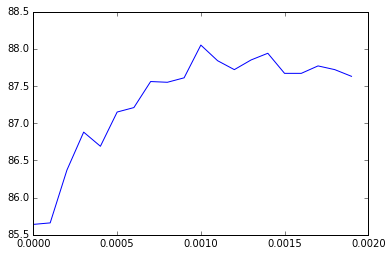

In [31]:
plt.plot(reg_par,test_prediction_accuracy)
print(max(test_prediction_accuracy))

In [35]:
batch_size = 128
beta = 0.0012

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(
      tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    reg = tf.nn.l2_loss(weights)
    new_loss = loss + beta*reg

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(new_loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
      tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
      if (step % 500 == 0):
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        print("Validation accuracy: %.1f%%" % accuracy(
          valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    #test_prediction_accuracy.append(accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 19.352833
Minibatch accuracy: 10.9%
Validation accuracy: 10.2%
Minibatch loss at step 500: 1.293468
Minibatch accuracy: 73.4%
Validation accuracy: 76.4%
Minibatch loss at step 1000: 0.855478
Minibatch accuracy: 81.2%
Validation accuracy: 79.2%
Minibatch loss at step 1500: 0.813192
Minibatch accuracy: 80.5%
Validation accuracy: 80.3%
Minibatch loss at step 2000: 0.774765
Minibatch accuracy: 81.2%
Validation accuracy: 81.5%
Minibatch loss at step 2500: 0.475428
Minibatch accuracy: 85.9%
Validation accuracy: 82.4%
Minibatch loss at step 3000: 0.756043
Minibatch accuracy: 82.0%
Validation accuracy: 81.5%
Test accuracy: 87.7%


In [19]:
batch_size = 128
#beta = np.arange(1e-4, 1e-3, 1e-5).tolist()

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  reg = tf.nn.l2_loss(weights)
  new_loss = loss + beta*reg
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(new_loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

[0.0001, 0.00011, 0.00012, 0.00013000000000000002, 0.00014, 0.00015000000000000001, 0.00015999999999999999, 0.00017, 0.00017999999999999998, 0.00019, 0.00019999999999999998, 0.00021, 0.00021999999999999998, 0.00023, 0.00023999999999999998, 0.00025, 0.00026, 0.00027, 0.00028, 0.00029, 0.0003, 0.00031, 0.00031999999999999997, 0.00033, 0.00033999999999999997, 0.00035, 0.00035999999999999997, 0.00036999999999999994, 0.00037999999999999997, 0.00039, 0.00039999999999999996, 0.00040999999999999994, 0.00041999999999999996, 0.00043, 0.00043999999999999996, 0.00044999999999999993, 0.00045999999999999996, 0.00047, 0.00047999999999999996, 0.00049, 0.0005, 0.00051, 0.00052, 0.00053, 0.00054, 0.00055, 0.00056, 0.00057, 0.00058, 0.00059, 0.0006000000000000001, 0.00061, 0.00062, 0.00063, 0.0006399999999999999, 0.00065, 0.00066, 0.00067, 0.00068, 0.00069, 0.0007, 0.00071, 0.0007199999999999999, 0.00073, 0.00074, 0.00075, 0.00076, 0.00077, 0.00078, 0.00079, 0.0007999999999999999, 0.00081, 0.00082, 0.000

Let's run the computation.

In [18]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 17.239731
Minibatch accuracy: 12.5%
Validation accuracy: 35.2%
Minibatch loss at step 500: 33.095695
Minibatch accuracy: 66.4%
Validation accuracy: 65.6%
Minibatch loss at step 1000: 32.817204
Minibatch accuracy: 75.8%
Validation accuracy: 74.2%
Minibatch loss at step 1500: 81.062981
Minibatch accuracy: 53.1%
Validation accuracy: 59.4%
Minibatch loss at step 2000: 106.502563
Minibatch accuracy: 57.0%
Validation accuracy: 66.0%
Minibatch loss at step 2500: 41.086510
Minibatch accuracy: 68.8%
Validation accuracy: 68.8%
Minibatch loss at step 3000: 27.881639
Minibatch accuracy: 69.5%
Validation accuracy: 61.5%
Test accuracy: 66.6%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---
